In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
import os
import joblib

In [43]:
# Defind the correct order of columns
correct_order = ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
saved_label_encoders_path = ''
saved_processed_data_path = ''


# 1. Giới thiệu

Vấn đề, tầm quan trọng, mục tiêu dự án.

Giới thiệu tổng quan về dự án, tập trung vào việc dự đoán giá xe ở Ấn Độ và phân tích các yếu tố ảnh hưởng.

- Trình bày vấn đề: Dự đoán giá xe dựa trên các thuộc tính như tuổi xe, loại nhiên liệu, km đã đi, v.v., và phân cụm để hiểu phân khúc thị trường.

- Giải thích tầm quan trọng: Thị trường xe cũ ở Ấn Độ phát triển mạnh (khoảng 3,4 triệu xe giao dịch mỗi năm theo IJERT), ảnh hưởng bởi chính sách (BS-VI), và nhu cầu cá nhân hóa sau COVID-19.
- Đặt mục tiêu: Xây dựng mô hình Random Forest để dự đoán giá xe chính xác.
Sử dụng K-Means để phân cụm xe thành các nhóm (ví dụ: xe giá rẻ, xe cao cấp).
Khám phá các yếu tố chính ảnh hưởng đến giá và phân khúc.

# 2. Hiểu dữ liệu

- Mô tả: Nguồn dữ liệu, mô tả các thuộc tính, số lượng bản ghi.
- Scope: Mô tả tập dữ liệu bạn đã có, đảm bảo phù hợp với thị trường Ấn Độ và đủ thông tin cho cả dự đoán giá và phân cụm.
- Quy trình:
    1. Nêu nguồn dữ liệu: Ví dụ, từ Kaggle, công ty ô tô, hoặc tự thu thập.
    2. Mô tả các thuộc tính: Liệt kê tất cả cột (giá, nhãn hiệu, năm sản xuất, loại nhiên liệu, km đã đi, loại truyền động, v.v.) và ý nghĩa của chúng.
    3. Thống kê cơ bản: Số lượng bản ghi (rows), số cột (columns), kiểu dữ liệu (numeric, categorical).
- Công việc cụ thể:
    - Dùng pandas trong Python để đọc dữ liệu (df.head(), df.info(), df.describe()).
    - Ghi chú các đặc điểm ban đầu: Ví dụ, "Dữ liệu gồm 10.000 xe, với giá từ 50.000 INR đến 5 triệu INR".
    - Kiểm tra xem dữ liệu có đại diện cho thị trường Ấn Độ không (nhiều nhãn hiệu như Maruti Suzuki, Hyundai không?).

#### Load dữ liệu

In [44]:
# Load Data
raw_df1 = pd.read_csv('cardekho.csv')
raw_df2 = pd.read_csv('train.csv')
raw_df3 = pd.read_csv('processes2.csv')


#### Hiển thị, mô tả các thuộc tính, số lượng bản ghi

In [45]:
print(raw_df1.shape)
raw_df1.head()

(8128, 12)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [46]:
print(raw_df2.shape)
raw_df2.head()

(5847, 14)


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
1,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13 km/kg,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
2,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN,3.50


In [47]:
print(raw_df3.shape)
raw_df3.head()

(2095, 14)


,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
1,2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,5,90.00,kmpl,23.00,1396
2,4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,5,81.86,kmpl,20.14,1197
3,7,Toyota,2011,350000,90000,Diesel,Individual,Manual,First Owner,5,67.10,kmpl,23.59,1364
4,8,Ford,2013,200000,169000,Diesel,Individual,Manual,First Owner,5,68.10,kmpl,20.00,1399


# 3. Phân tích Khám phá Dữ liệu (EDA)

- Mô tả: Thống kê, biểu đồ, mối quan hệ giữa giá và các yếu tố.
- Scope: Hiểu dữ liệu thô, phát hiện xu hướng, vấn đề (giá trị thiếu, ngoại lai), và chuẩn bị cho phân cụm K-Means.
- Quy trình:
    1. Thống kê mô tả: Tính trung bình, trung vị, độ lệch chuẩn của giá, tuổi xe, km đã đi.
    2. Trực quan hóa:
        -  Biểu đồ phân phối giá (histogram) để xem phân khúc giá phổ biến.
        -  Biểu đồ phân tán (scatter plot) giữa giá và tuổi xe/km đã đi.
        -  Biểu đồ hộp (box plot) để phát hiện ngoại lai (ví dụ: giá xe bất thường > 10 triệu INR).
        -  Biểu đồ thanh (bar plot) để so sánh giá trung bình theo loại nhiên liệu/nhãn hiệu.
    3. Phân tích mối quan hệ: Tính tương quan (correlation) giữa giá và các biến số (dùng df.corr()).
- Công việc cụ thể:
    - Sử dụng thư viện như matplotlib, seaborn để vẽ biểu đồ.
    - Ghi nhận phát hiện: Ví dụ, "Xe dầu diesel có giá trung bình cao hơn xe xăng 15%".
    - Chuẩn bị cho K-Means: Xem các biến như giá, km đã đi, tuổi xe có thể phân cụm xe thành các nhóm không.

**Dựa trên những thuộc tính đã khám phá từ 2., xử lý sơ bộ bằng các chuyển kiểu dữ liệu về cho đúng để thuận tiện cho việc EDA**

## Chuẩn hóa tên cột của tập dữ liệu, kiểu dữ liệu và đơn vị

In [48]:
raw_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


In [49]:
raw_df1 = raw_df1[(raw_df1['fuel']!='CNG') & (raw_df1['fuel']!='LPG') & (raw_df1['owner']!='Test Drive Car')]
raw_df1['owner'] = raw_df1['owner'].str.replace(' Owner','',regex=True)
raw_df1['name'] = raw_df1['name'].str.split().str[0]# .str.title()
raw_df1['selling_price'] = raw_df1['selling_price'] / 100000.0

In [50]:
# Dictionary ánh xạ từ tên cột cũ sang tên cột mới
column_mapping_df1 = {
    "mileage(km/ltr/kg)": "mileage"
}
raw_df1 = raw_df1.drop(columns=['seller_type'])
raw_df1.rename(columns=column_mapping_df1, inplace=True)
print(raw_df1.columns)
raw_df1.head()

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'transmission',
       'owner', 'mileage', 'engine', 'max_power', 'seats'],
      dtype='object')


,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,4.50,145500,Diesel,Manual,First,23.40,1248.0,74,5.0
1,Skoda,2014,3.70,120000,Diesel,Manual,Second,21.14,1498.0,103.52,5.0
2,Honda,2006,1.58,140000,Petrol,Manual,Third,17.70,1497.0,78,5.0
3,Hyundai,2010,2.25,127000,Diesel,Manual,First,23.00,1396.0,90,5.0
4,Maruti,2007,1.30,120000,Petrol,Manual,First,16.10,1298.0,88.2,5.0


In [51]:
raw_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5847 non-null   int64  
 1   Name               5847 non-null   object 
 2   Location           5847 non-null   object 
 3   Year               5847 non-null   int64  
 4   Kilometers_Driven  5847 non-null   int64  
 5   Fuel_Type          5847 non-null   object 
 6   Transmission       5847 non-null   object 
 7   Owner_Type         5847 non-null   object 
 8   Mileage            5845 non-null   object 
 9   Engine             5811 non-null   object 
 10  Power              5811 non-null   object 
 11  Seats              5809 non-null   float64
 12  New_Price          815 non-null    object 
 13  Price              5847 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 639.6+ KB


In [52]:
print(raw_df2['Owner_Type'].unique())
raw_df2 = raw_df2[raw_df2['Fuel_Type']!='Electric']
raw_df2['Engine'] = raw_df2['Engine'].str.extract('(\d+)')  # Lấy chỉ số trong chuỗi
raw_df2['Power'] = raw_df2['Power'].str.extract('(\d+)')  # Lấy chỉ số trong chuỗi
raw_df2['Mileage'] = raw_df2['Mileage'].str.extract('(\d+)')  # Lấy chỉ số trong chuỗi
raw_df2 = raw_df2[~raw_df2['Mileage'].str.contains('km/kg', na=False)]
raw_df2['Name'] = raw_df2['Name'].str.split(' ').str[0]
raw_df2.head()


['First' 'Second' 'Fourth & Above' 'Third']


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19,1582,126,5.0,NaN,12.50
1,2,Honda,Chennai,2011,46000,Petrol,Manual,First,13,1199,88,5.0,8.61 Lakh,4.50
2,3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20,1248,88,7.0,NaN,6.00
3,4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15,1968,140,5.0,NaN,17.74
4,6,Nissan,Jaipur,2013,86999,Diesel,Manual,First,23,1461,63,5.0,NaN,3.50


In [53]:
column_mapping_df2 = {
        "Year": "year",
        "Kilometers_Driven": "km_driven",
        "Fuel_Type": "fuel",
        "Transmission": "transmission",
        "Mileage": "mileage",
        "Engine": "engine",
        "Power": "max_power",
        "Seats": "seats",
        "Price": "selling_price",
        "Name": "name",
        "Owner_Type": "owner"
    }
raw_df2 = raw_df2.drop(columns=['New_Price', 'Location','Unnamed: 0'])
raw_df2.rename(columns=column_mapping_df2, inplace=True)
raw_df2 = raw_df2[correct_order]
raw_df2.info()
raw_df2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5845 entries, 0 to 5846
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5845 non-null   object 
 1   year           5845 non-null   int64  
 2   selling_price  5845 non-null   float64
 3   km_driven      5845 non-null   int64  
 4   fuel           5845 non-null   object 
 5   transmission   5845 non-null   object 
 6   owner          5845 non-null   object 
 7   mileage        5845 non-null   object 
 8   engine         5809 non-null   object 
 9   max_power      5809 non-null   object 
 10  seats          5807 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 548.0+ KB


,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
0,Hyundai,2015,12.50,41000,Diesel,Manual,First,19,1582,126,5.0
1,Honda,2011,4.50,46000,Petrol,Manual,First,13,1199,88,5.0
2,Maruti,2012,6.00,87000,Diesel,Manual,First,20,1248,88,7.0
3,Audi,2013,17.74,40670,Diesel,Automatic,Second,15,1968,140,5.0
4,Nissan,2013,3.50,86999,Diesel,Manual,First,23,1461,63,5.0


In [54]:
raw_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2095 non-null   int64  
 1   name                2095 non-null   object 
 2   year                2095 non-null   int64  
 3   selling_price       2095 non-null   int64  
 4   km_driven           2095 non-null   int64  
 5   fuel                2095 non-null   object 
 6   seller_type         2095 non-null   object 
 7   transmission        2095 non-null   object 
 8   owner               2095 non-null   object 
 9   seats               2095 non-null   int64  
 10  max_power (in bph)  2095 non-null   float64
 11  Mileage Unit        2095 non-null   object 
 12  Mileage             2095 non-null   float64
 13  Engine (CC)         2095 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 229.3+ KB


In [55]:
# Đọc dữ liệu từ file csv
raw_df3 = pd.read_csv('processes2.csv')
raw_df3 = raw_df3[(raw_df3['fuel']!='CNG') & (raw_df3['fuel']!='LPG') & (raw_df3['owner']!='Test Drive Car')]
raw_df3['owner'] = raw_df3['owner'].str.replace(' Owner','',regex=True)
raw_df3['selling_price'] = raw_df3['selling_price'] / 100000.0
print(raw_df3['fuel'].unique())
print(raw_df3['owner'].unique())
raw_df3.head()

['Diesel' 'Petrol']
['First' 'Second' 'Third' 'Fourth & Above']


,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,2014,4.50,145500,Diesel,Individual,Manual,First,5,74.00,kmpl,23.40,1248
1,2,Hyundai,2010,2.25,127000,Diesel,Individual,Manual,First,5,90.00,kmpl,23.00,1396
2,4,Hyundai,2017,4.40,45000,Petrol,Individual,Manual,First,5,81.86,kmpl,20.14,1197
3,7,Toyota,2011,3.50,90000,Diesel,Individual,Manual,First,5,67.10,kmpl,23.59,1364
4,8,Ford,2013,2.00,169000,Diesel,Individual,Manual,First,5,68.10,kmpl,20.00,1399


In [56]:
column_mapping_df3 = {
        "max_power (in bph)": "max_power",
        "Mileage": "mileage",
        "Engine (CC)": "engine"
    }
raw_df3 = raw_df3.drop(columns=['seller_type', 'Mileage Unit', 'Unnamed: 0'])
raw_df3.rename(columns=column_mapping_df3, inplace=True)
raw_df3 = raw_df3[correct_order]

In [57]:
def plot_histograms(df, columns, figsize=(15, 12), bins_method='sqrt'):
    """
    Vẽ histogram cho các cột liên tục trong DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        columns (list): Danh sách tên các cột cần vẽ histogram.
        figsize (tuple): Kích thước của figure (mặc định là (15, 12)).
        bins_method (str): Phương pháp tính bin cho numpy.histogram_bin_edges() (mặc định là 'sqrt').

    Returns:
        None (Hiển thị biểu đồ).
    """
    plt.figure(figsize=figsize)

    for index, col in enumerate(columns):
        plt.subplot(2, 2, index + 1)
        
        # Chuyển cột về kiểu số, bỏ giá trị không hợp lệ
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        
        # Tính toán bin edges bằng phương pháp chỉ định
        bin_edges = np.histogram_bin_edges(data, bins=bins_method)
        num_bins = len(bin_edges) - 1  # Số bin thực tế
        
        # Vẽ histogram với số bin tính toán được
        sns.histplot(data=data, bins=num_bins, color=sns.color_palette('pastel')[index], kde=True)
        
        plt.title(col.replace('_', ' ').capitalize(), fontsize=14, pad=10)
        plt.xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tick_params(axis='both', labelsize=10)

    plt.tight_layout()
    plt.show()

In [58]:
continuous_raw_columns = ['km_driven', 'mileage', 'engine', 'max_power']

In [59]:
raw_df1.info()
raw_df1.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 8127
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8028 non-null   object 
 1   year           8028 non-null   int64  
 2   selling_price  8028 non-null   float64
 3   km_driven      8028 non-null   int64  
 4   fuel           8028 non-null   object 
 5   transmission   8028 non-null   object 
 6   owner          8028 non-null   object 
 7   mileage        7814 non-null   float64
 8   engine         7814 non-null   float64
 9   max_power      7820 non-null   object 
 10  seats          7814 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 752.6+ KB


,year,selling_price,km_driven,mileage,engine,seats
count,8028.000000,8028.000000,8.028000e+03,7814.000000,7814.000000,7814.000000
mean,2013.815521,6.403937,6.977314e+04,19.391962,1462.914640,5.421551
std,4.030836,8.027015,5.664419e+04,4.001972,504.759742,0.963125
min,1983.000000,0.299990,1.000000e+03,0.000000,624.000000,2.000000
25%,2011.000000,2.600000,3.500000e+04,16.780000,1197.000000,5.000000
50%,2015.000000,4.500000,6.000000e+04,19.300000,1248.000000,5.000000
75%,2017.000000,6.800000,9.800000e+04,22.320000,1582.000000,5.000000
max,2020.000000,100.000000,2.360457e+06,42.000000,3604.000000,14.000000


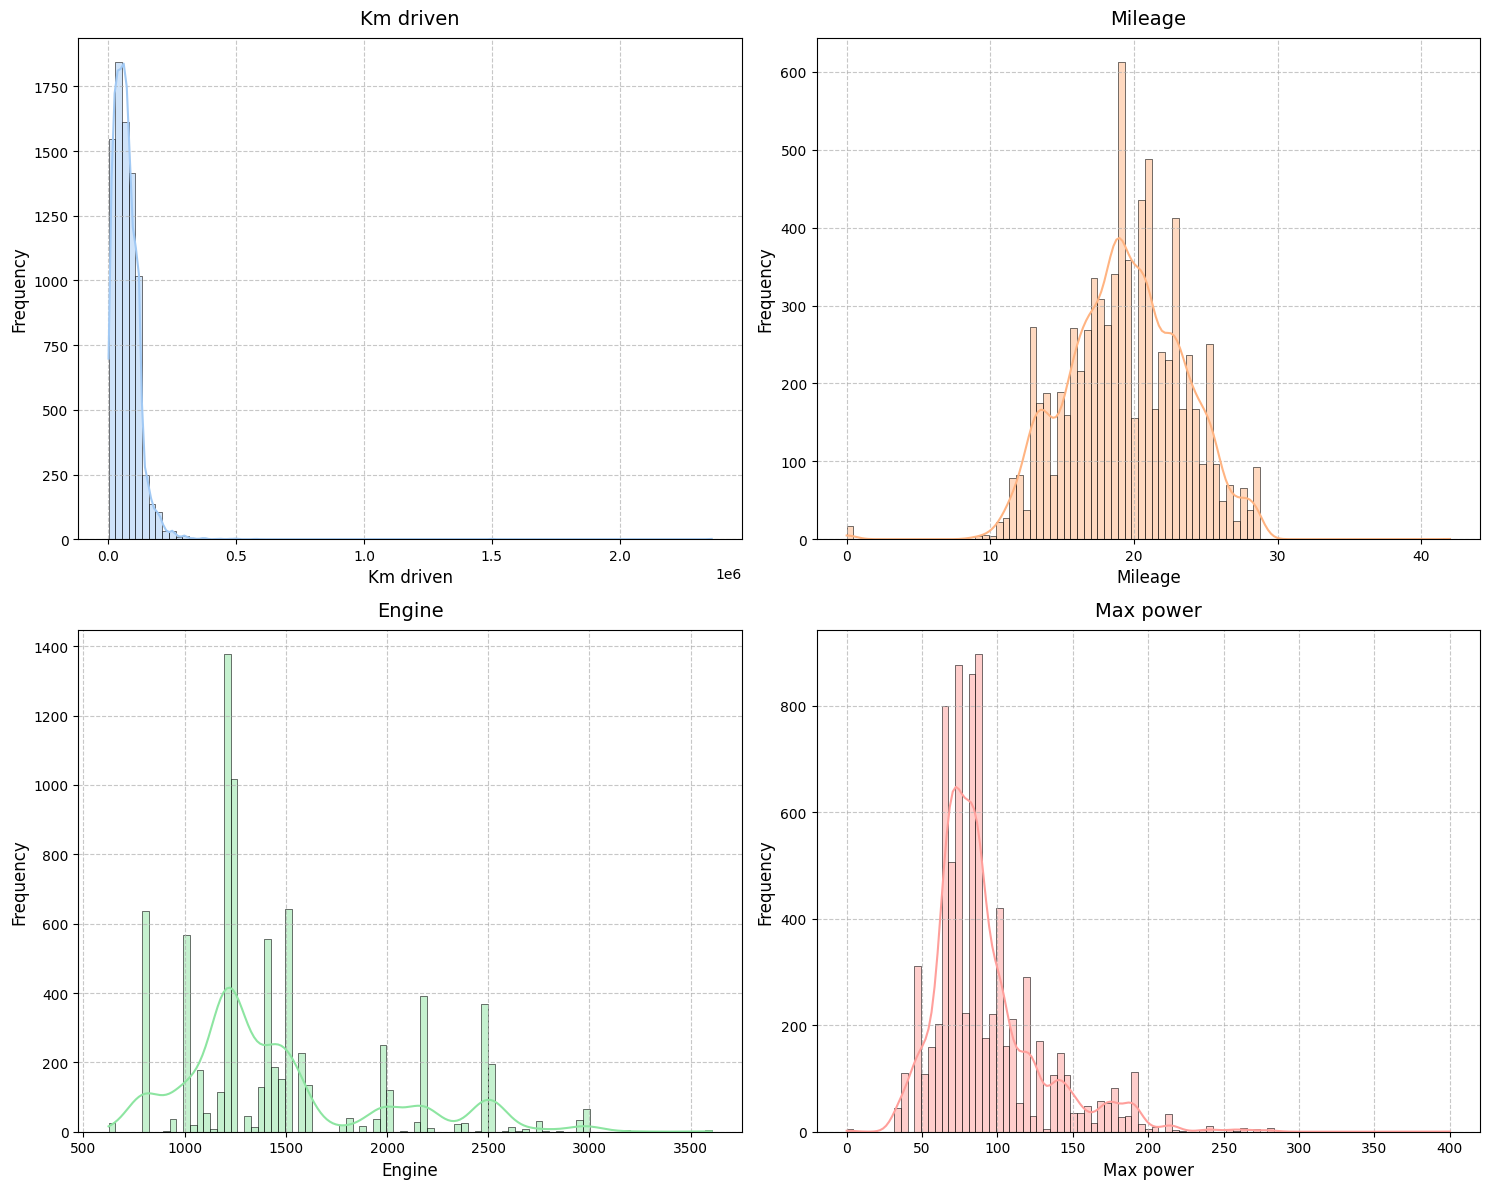

In [60]:
plot_histograms(raw_df1, continuous_raw_columns)

In [61]:
raw_df2.info()
raw_df2.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5845 entries, 0 to 5846
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5845 non-null   object 
 1   year           5845 non-null   int64  
 2   selling_price  5845 non-null   float64
 3   km_driven      5845 non-null   int64  
 4   fuel           5845 non-null   object 
 5   transmission   5845 non-null   object 
 6   owner          5845 non-null   object 
 7   mileage        5845 non-null   object 
 8   engine         5809 non-null   object 
 9   max_power      5809 non-null   object 
 10  seats          5807 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 548.0+ KB


,year,selling_price,km_driven,seats
count,5845.000000,5845.000000,5.845000e+03,5807.000000
mean,2013.448417,9.652640,5.841404e+04,5.286551
std,3.195161,11.277737,9.239526e+04,0.806790
min,1998.000000,0.440000,1.710000e+02,2.000000
25%,2012.000000,3.550000,3.345000e+04,5.000000
50%,2014.000000,5.750000,5.260000e+04,5.000000
75%,2016.000000,10.250000,7.249500e+04,5.000000
max,2019.000000,160.000000,6.500000e+06,10.000000


In [62]:
# plot_histograms(raw_df2, continuous_raw_columns)

In [63]:
raw_df3.info()
raw_df3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2074 entries, 0 to 2094
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2074 non-null   object 
 1   year           2074 non-null   int64  
 2   selling_price  2074 non-null   float64
 3   km_driven      2074 non-null   int64  
 4   fuel           2074 non-null   object 
 5   transmission   2074 non-null   object 
 6   owner          2074 non-null   object 
 7   mileage        2074 non-null   float64
 8   engine         2074 non-null   int64  
 9   max_power      2074 non-null   float64
 10  seats          2074 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 194.4+ KB


,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,4.50,145500,Diesel,Manual,First,23.40,1248,74.00,5
1,Hyundai,2010,2.25,127000,Diesel,Manual,First,23.00,1396,90.00,5
2,Hyundai,2017,4.40,45000,Petrol,Manual,First,20.14,1197,81.86,5
3,Toyota,2011,3.50,90000,Diesel,Manual,First,23.59,1364,67.10,5
4,Ford,2013,2.00,169000,Diesel,Manual,First,20.00,1399,68.10,5


In [64]:
# plot_histograms(raw_df3, continuous_raw_columns)

## Trộn và lưu dữ liệu

In [65]:
# Merge 3 datasets
merged_df = pd.concat([raw_df1, raw_df2, raw_df3], ignore_index=True)

# Export to CSV file
saved_file_path = 'merged_dataset.csv'
merged_df.to_csv(saved_file_path, index=False)

# Print message
print(f"Merged and saved to '{saved_file_path}'")

Merged and saved to 'merged_dataset.csv'


## Load merged data

In [66]:
merged_df = pd.read_csv(saved_file_path)
print(merged_df.shape)
merged_df.head()

(15947, 11)


,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,4.50,145500,Diesel,Manual,First,23.40,1248.0,74.00,5.0
1,Skoda,2014,3.70,120000,Diesel,Manual,Second,21.14,1498.0,103.52,5.0
2,Honda,2006,1.58,140000,Petrol,Manual,Third,17.70,1497.0,78.00,5.0
3,Hyundai,2010,2.25,127000,Diesel,Manual,First,23.00,1396.0,90.00,5.0
4,Maruti,2007,1.30,120000,Petrol,Manual,First,16.10,1298.0,88.20,5.0


In [67]:
merged_df.info()
merged_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15947 entries, 0 to 15946
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           15947 non-null  object 
 1   year           15947 non-null  int64  
 2   selling_price  15947 non-null  float64
 3   km_driven      15947 non-null  int64  
 4   fuel           15947 non-null  object 
 5   transmission   15947 non-null  object 
 6   owner          15947 non-null  object 
 7   mileage        15733 non-null  float64
 8   engine         15697 non-null  float64
 9   max_power      15703 non-null  float64
 10  seats          15695 non-null  float64
dtypes: float64(5), int64(2), object(4)
memory usage: 1.3+ MB


,year,selling_price,km_driven,mileage,engine,max_power,seats
count,15947.000000,15947.000000,1.594700e+04,15733.000000,15697.000000,15703.000000,15695.000000
mean,2013.708848,7.317741,6.530429e+04,19.038960,1491.325285,97.953659,5.328703
std,3.654452,9.130975,7.067008e+04,4.080677,536.029927,43.934431,0.861552
min,1983.000000,0.299990,1.710000e+02,0.000000,624.000000,0.000000,2.000000
25%,2012.000000,2.915000,3.468700e+04,16.300000,1197.000000,70.000000,5.000000
50%,2014.000000,4.800000,5.900000e+04,19.330000,1364.000000,85.800000,5.000000
75%,2016.000000,7.450000,8.583650e+04,22.000000,1598.000000,110.000000,5.000000
max,2020.000000,160.000000,6.500000e+06,42.000000,5998.000000,560.000000,14.000000


In [68]:
# Take copy from data to make processes on
preprocessed_df = deepcopy(merged_df)

# Show all types of columns in the data
preprocessed_df.dtypes

name              object
year               int64
selling_price    float64
km_driven          int64
fuel              object
transmission      object
owner             object
mileage          float64
engine           float64
max_power        float64
seats            float64
dtype: object

In [69]:
# Check about none values in data to decide if we will make data cleaning or not
preprocessed_df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
transmission       0
owner              0
mileage          214
engine           250
max_power        244
seats            252
dtype: int64

In [70]:
print("Count of zero values per column:\n", (preprocessed_df == 0).sum())

Count of zero values per column:
 name              0
year              0
selling_price     0
km_driven         0
fuel              0
transmission      0
owner             0
mileage          57
engine            0
max_power         6
seats             0
dtype: int64


Hàm xử lý các bộ data

In [71]:
df_2005_2010 = preprocessed_df[(preprocessed_df['year'] >= 2005) & (preprocessed_df['year'] < 2010)]
df_2010_2015 = preprocessed_df[(preprocessed_df['year'] >= 2010) & (preprocessed_df['year'] < 2015)]
df_2015_2021 = preprocessed_df[(preprocessed_df['year'] >= 2015) & (preprocessed_df['year'] < 2022)]
preprocessed_df.head()


,name,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,4.50,145500,Diesel,Manual,First,23.40,1248.0,74.00,5.0
1,Skoda,2014,3.70,120000,Diesel,Manual,Second,21.14,1498.0,103.52,5.0
2,Honda,2006,1.58,140000,Petrol,Manual,Third,17.70,1497.0,78.00,5.0
3,Hyundai,2010,2.25,127000,Diesel,Manual,First,23.00,1396.0,90.00,5.0
4,Maruti,2007,1.30,120000,Petrol,Manual,First,16.10,1298.0,88.20,5.0


In [72]:
def cleanData(preprocess_df, name):
    cols_to_replace_zeros = ['mileage', 'max_power']
    preprocess_df[cols_to_replace_zeros] = preprocess_df[cols_to_replace_zeros].replace(0, np.nan)
    # Handle missing values of float columns that are mileage, engine, seats
    column_float_imputed = ['mileage', 'engine', 'max_power']
    preprocess_df[column_float_imputed] = preprocess_df[column_float_imputed].fillna(preprocess_df[column_float_imputed].mean())

    # Handle missing values of seats column 
    preprocess_df['seats'] = preprocess_df['seats'].fillna(preprocess_df['seats'].mode()[0])

    # Show all textual columns in the dataset
    textual_columns = preprocess_df.select_dtypes(include = ['object']).columns
    preprocess_df[textual_columns]
    label_encoders = {}

    # Fit and transform each textual column, saving the encoders
    for col in textual_columns:
        label_encoder = LabelEncoder()
        preprocess_df[col] = label_encoder.fit_transform(preprocess_df[col])
        label_encoders[col] = label_encoder

    # Check about if there is any extra textual columns
    preprocess_df.select_dtypes(include=['object']).columns
    preprocess_df['km_driven'] = np.log(preprocess_df['km_driven'] + 1)
    processed_data_dir = "processed_data"
    saved_processed_data_path = os.path.join(processed_data_dir, name + ".csv")
    saved_label_encoders_path = os.path.join(processed_data_dir, "label_encoders.sav")

    # Tạo thư mục nếu chưa tồn tại
    os.makedirs(processed_data_dir, exist_ok=True)

    # Ghi DataFrame ra CSV
    preprocess_df.to_csv(saved_processed_data_path, index=False)

    # Lưu label encoders
    joblib.dump(label_encoders, saved_label_encoders_path)


In [73]:
cleanData(df_2005_2010, name='preprocessed_dataset_2005_2010')
cleanData(df_2010_2015, name='preprocessed_dataset_2010_2015')
cleanData(df_2015_2021, name='preprocessed_dateset_2015_2021')
cleanData(preprocessed_df, name='preprocessed_dataset')


C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\1957674624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df[cols_to_replace_zeros] = preprocess_df[cols_to_replace_zeros].replace(0, np.nan)
C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\1957674624.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df[column_float_imputed] = preprocess_df[column_float_imputed].fillna(preprocess_df[column_float_imputed].mean())
C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\1957674624.py:9: Se

In [74]:
preprocessed_dataset_2005_2010 = pd.read_csv('processed_data\preprocessed_dataset_2005_2010.csv')
preprocessed_dataset_2010_2015 = pd.read_csv('processed_data\preprocessed_dataset_2010_2015.csv')
preprocessed_dateset_2015_2021 = pd.read_csv('processed_data\preprocessed_dateset_2015_2021.csv')
preprocessed_dataset = pd.read_csv('processed_data\preprocessed_dataset.csv')
print(preprocessed_dataset_2005_2010.shape)
print(preprocessed_dataset_2010_2015.shape)
print(preprocessed_dateset_2015_2021.shape)
print(preprocessed_dataset.shape)

(1565, 11)
(6608, 11)
(7473, 11)
(15947, 11)


In [82]:
def cleanDataNoLog(preprocess_df, name):
    cols_to_replace_zeros = ['mileage', 'max_power']
    preprocess_df[cols_to_replace_zeros] = preprocess_df[cols_to_replace_zeros].replace(0, np.nan)
    # Handle missing values of float columns that are mileage, engine, seats
    column_float_imputed = ['mileage', 'engine', 'max_power']
    preprocess_df[column_float_imputed] = preprocess_df[column_float_imputed].fillna(preprocess_df[column_float_imputed].mean())

    # Handle missing values of seats column 
    preprocess_df['seats'] = preprocess_df['seats'].fillna(preprocess_df['seats'].mode()[0])

    # Show all textual columns in the dataset
    textual_columns = preprocess_df.select_dtypes(include = ['object']).columns
    preprocess_df[textual_columns]
    label_encoders = {}

    # Fit and transform each textual column, saving the encoders
    for col in textual_columns:
        label_encoder = LabelEncoder()
        preprocess_df[col] = label_encoder.fit_transform(preprocess_df[col])
        label_encoders[col] = label_encoder

    # Check about if there is any extra textual columns
    preprocess_df.select_dtypes(include=['object']).columns
    processed_data_dir = "processed_data"
    saved_processed_data_path = os.path.join(processed_data_dir, name + "noLog.csv")
    saved_label_encoders_path = os.path.join(processed_data_dir, "label_encoders.sav")

    # Tạo thư mục nếu chưa tồn tại
    os.makedirs(processed_data_dir, exist_ok=True)

    # Ghi DataFrame ra CSV
    preprocess_df.to_csv(saved_processed_data_path, index=False)

    # Lưu label encoders
    joblib.dump(label_encoders, saved_label_encoders_path)


In [83]:
cleanDataNoLog(df_2005_2010, 'preprocessed_dataset_2005_2010')
cleanDataNoLog(df_2010_2015, 'preprocessed_dataset_2010_2015')
cleanDataNoLog(df_2015_2021, 'preprocessed_dateset_2015_2021')
cleanDataNoLog(preprocessed_df,'preprocessed_dataset')

C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\136447236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df[cols_to_replace_zeros] = preprocess_df[cols_to_replace_zeros].replace(0, np.nan)
C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\136447236.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_df[column_float_imputed] = preprocess_df[column_float_imputed].fillna(preprocess_df[column_float_imputed].mean())
C:\Users\phamt\AppData\Local\Temp\ipykernel_9320\136447236.py:9: Setti

In [77]:
preprocessed_dataset_2005_2010_noLog = pd.read_csv('processed_data\preprocessed_dataset_2005_2010noLog.csv')
preprocessed_dataset_2010_2015_noLog = pd.read_csv('processed_data\preprocessed_dataset_2010_2015noLog.csv')
preprocessed_dateset_2015_2021_noLog = pd.read_csv('processed_data\preprocessed_dateset_2015_2021noLog.csv')
preprocessed_dataset_noLog = pd.read_csv('processed_data\preprocessed_datasetnoLog.csv')

## Handling outliers

Vẽ biểu đồ thể hiện độ lệch

In [78]:
def chart(preprocessed_df, name):
    # Remove selling_price column
    column_skewed = preprocessed_df.columns.drop('selling_price')

    # Compute skewness for each column
    skewness = preprocessed_df.drop(columns=['selling_price']).skew()
    print(skewness)

    plt.figure(figsize=(15, 7))
    sns.barplot(x=column_skewed, y=skewness, hue=column_skewed, palette='coolwarm')

    plt.title('Skewness of Features in Car Dataset ' + name, fontsize=16, pad=20)

    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Skewness', fontsize=12)

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.xticks(rotation=45, ha='right', fontsize=10)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

name            0.036428
year           -0.537929
km_driven      -0.844081
fuel           -0.625893
transmission   -2.329846
owner          -0.160154
mileage        -0.362657
engine          1.235324
max_power       2.663633
seats           2.467617
dtype: float64


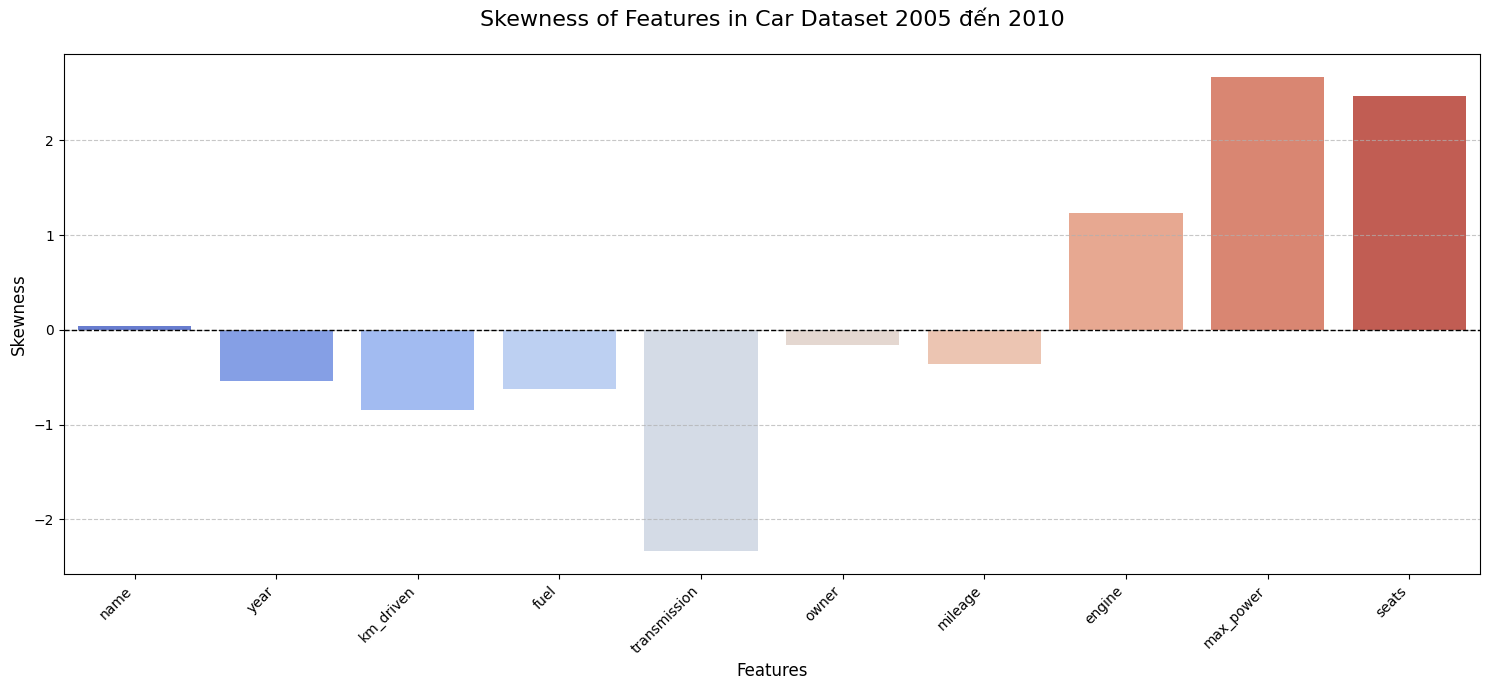

name            0.151428
year           -0.238725
km_driven      -0.583997
fuel            0.513182
transmission   -2.103153
owner           0.689568
mileage        -0.353391
engine          1.479082
max_power       2.447190
seats           2.123261
dtype: float64


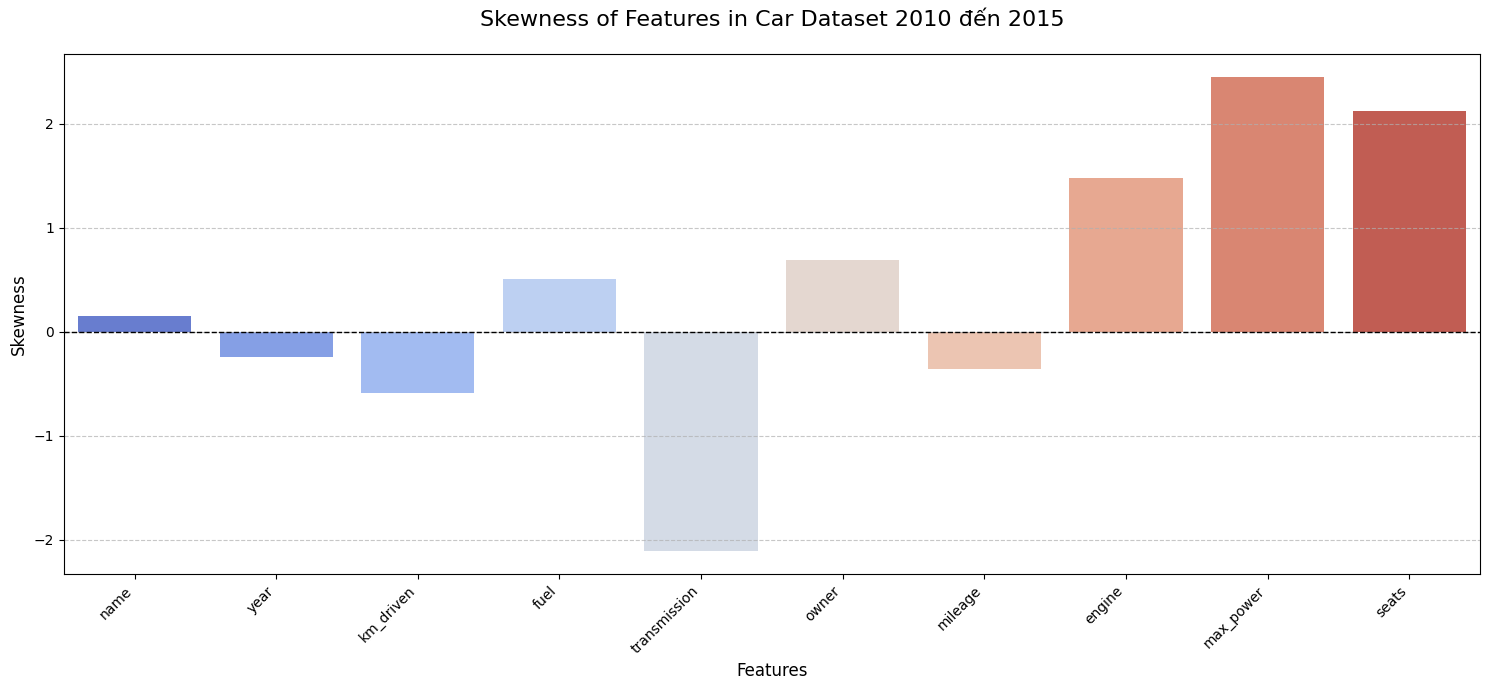

name           -0.017403
year            0.329326
km_driven      -0.898712
fuel            0.087080
transmission   -1.263620
owner           2.602356
mileage        -0.129910
engine          1.476889
max_power       1.906936
seats           2.110156
dtype: float64


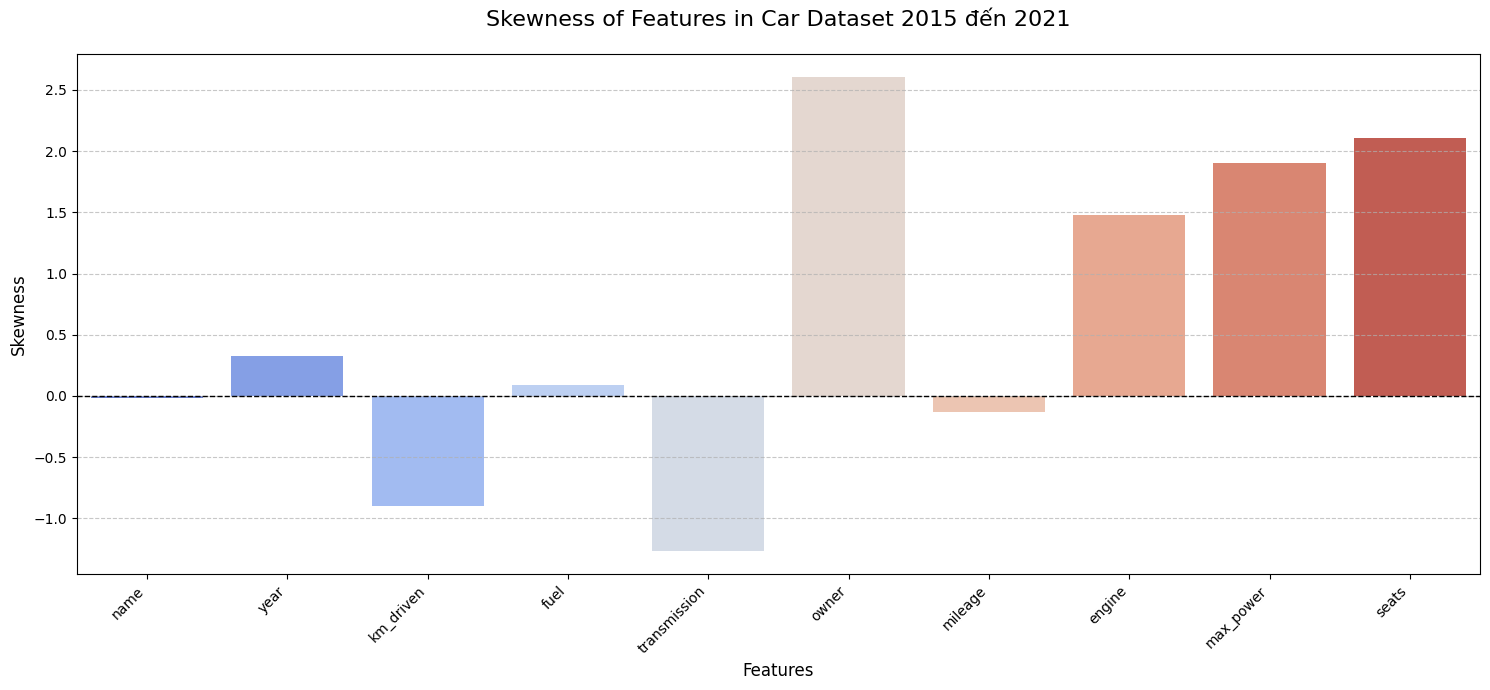

name           -0.015550
year           -0.950981
km_driven      -1.119646
fuel            0.166768
transmission   -1.674586
owner           1.140772
mileage        -0.149842
engine          1.452807
max_power       2.196668
seats           2.178515
dtype: float64


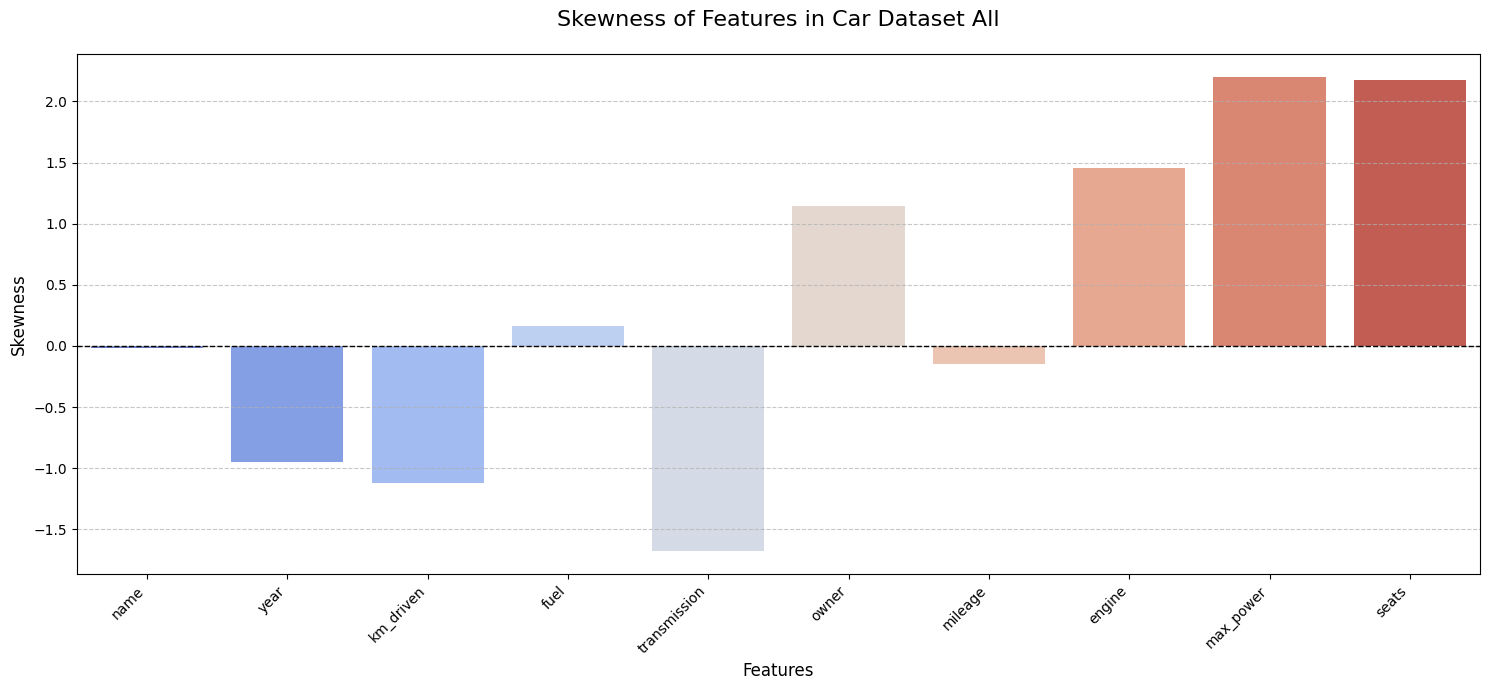

name            0.036428
year           -0.537929
km_driven      -0.844081
fuel           -0.625893
transmission   -2.329846
owner          -0.160154
mileage        -0.362657
engine          1.235324
max_power       2.663633
seats           2.467617
dtype: float64


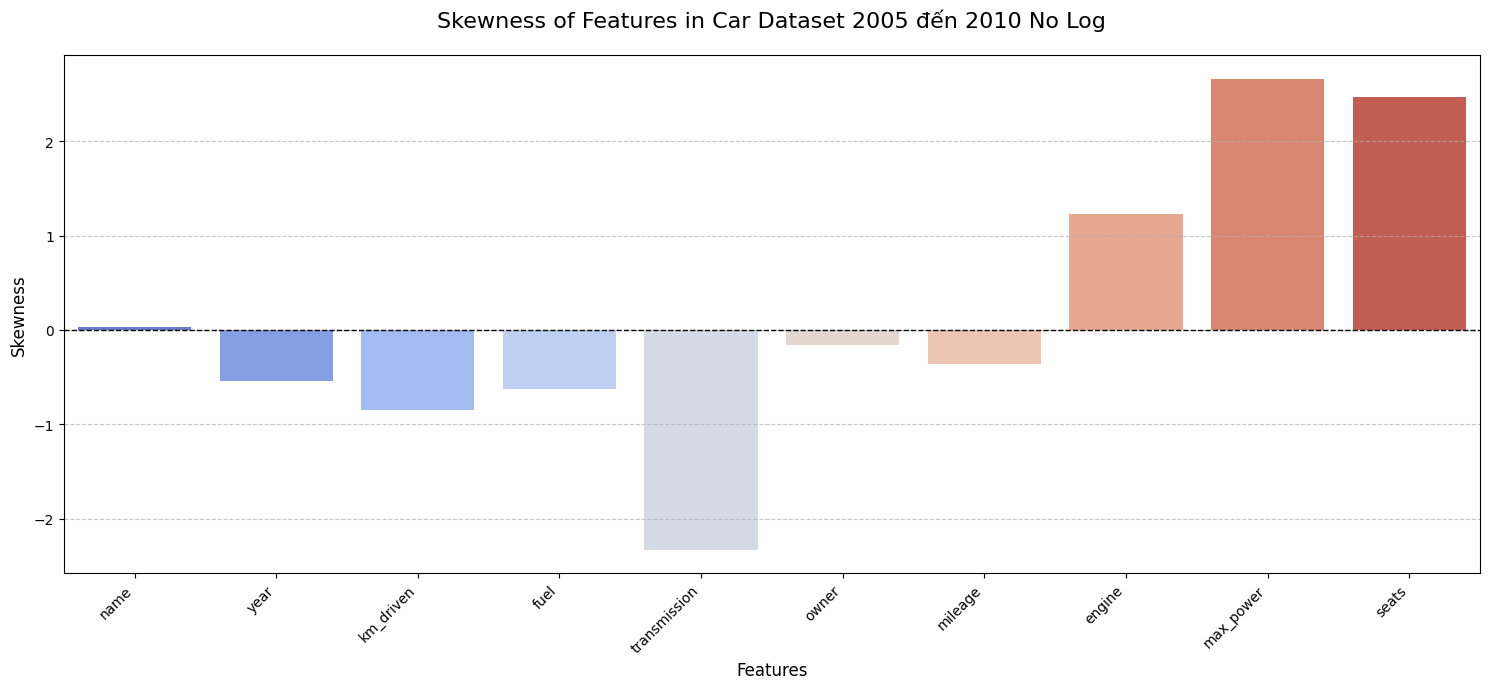

name            0.151428
year           -0.238725
km_driven      -0.583997
fuel            0.513182
transmission   -2.103153
owner           0.689568
mileage        -0.353391
engine          1.479082
max_power       2.447190
seats           2.123261
dtype: float64


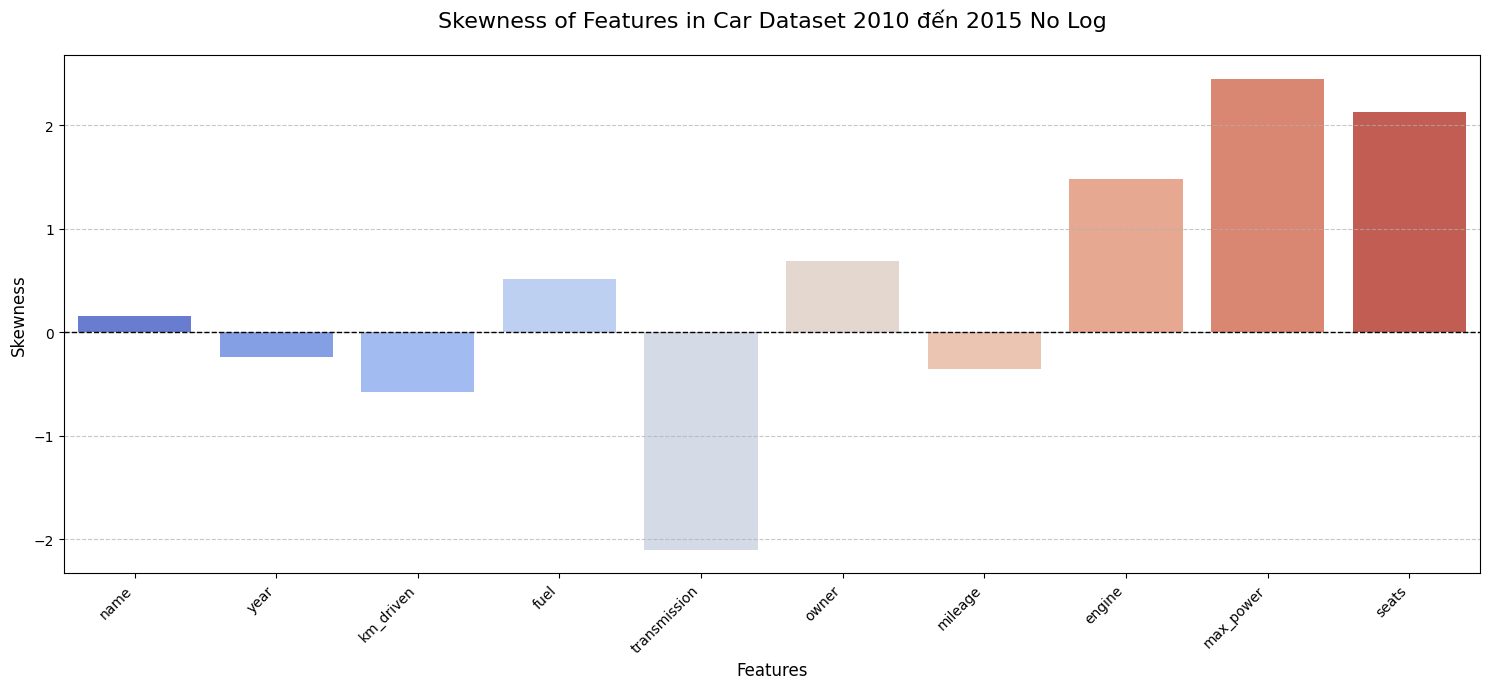

name           -0.017403
year            0.329326
km_driven      -0.898712
fuel            0.087080
transmission   -1.263620
owner           2.602356
mileage        -0.129910
engine          1.476889
max_power       1.906936
seats           2.110156
dtype: float64


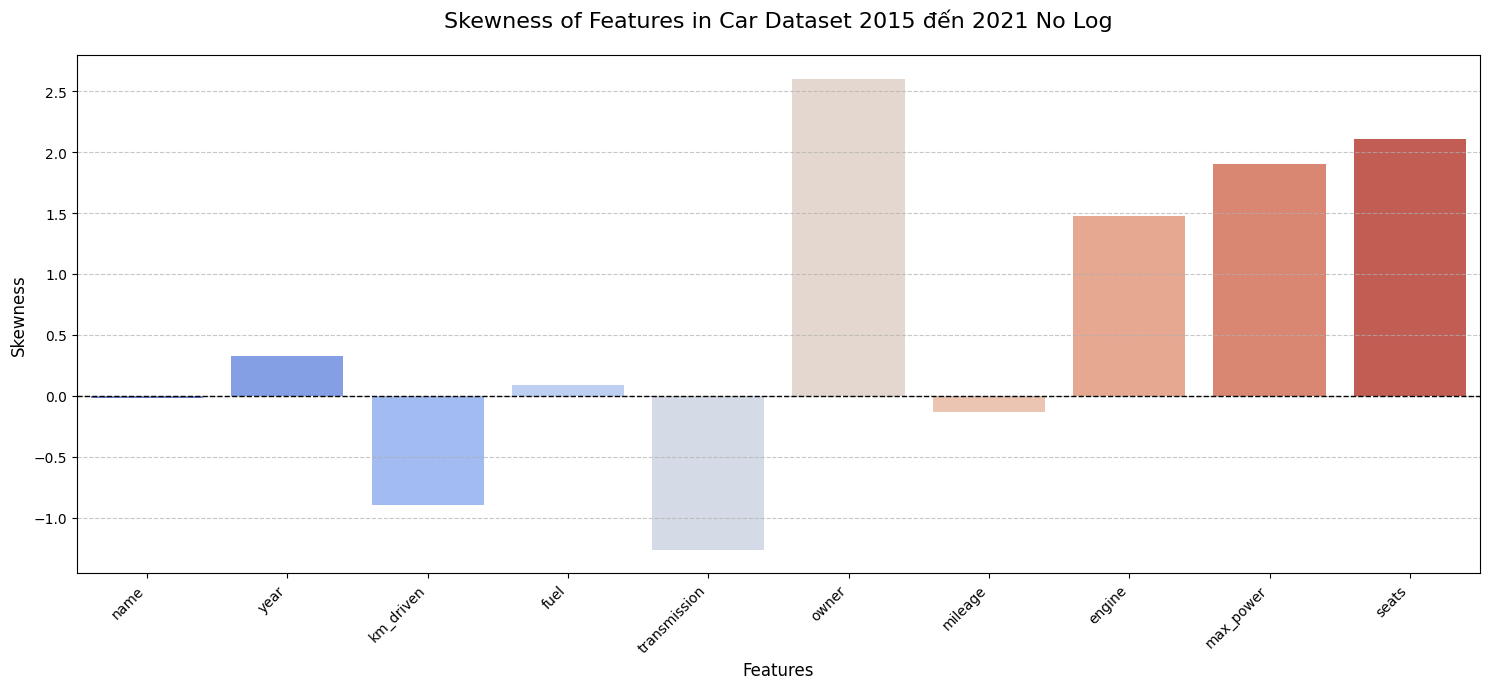

name           -0.015550
year           -0.950981
km_driven      -1.119646
fuel            0.166768
transmission   -1.674586
owner           1.140772
mileage        -0.149842
engine          1.452807
max_power       2.196668
seats           2.178515
dtype: float64


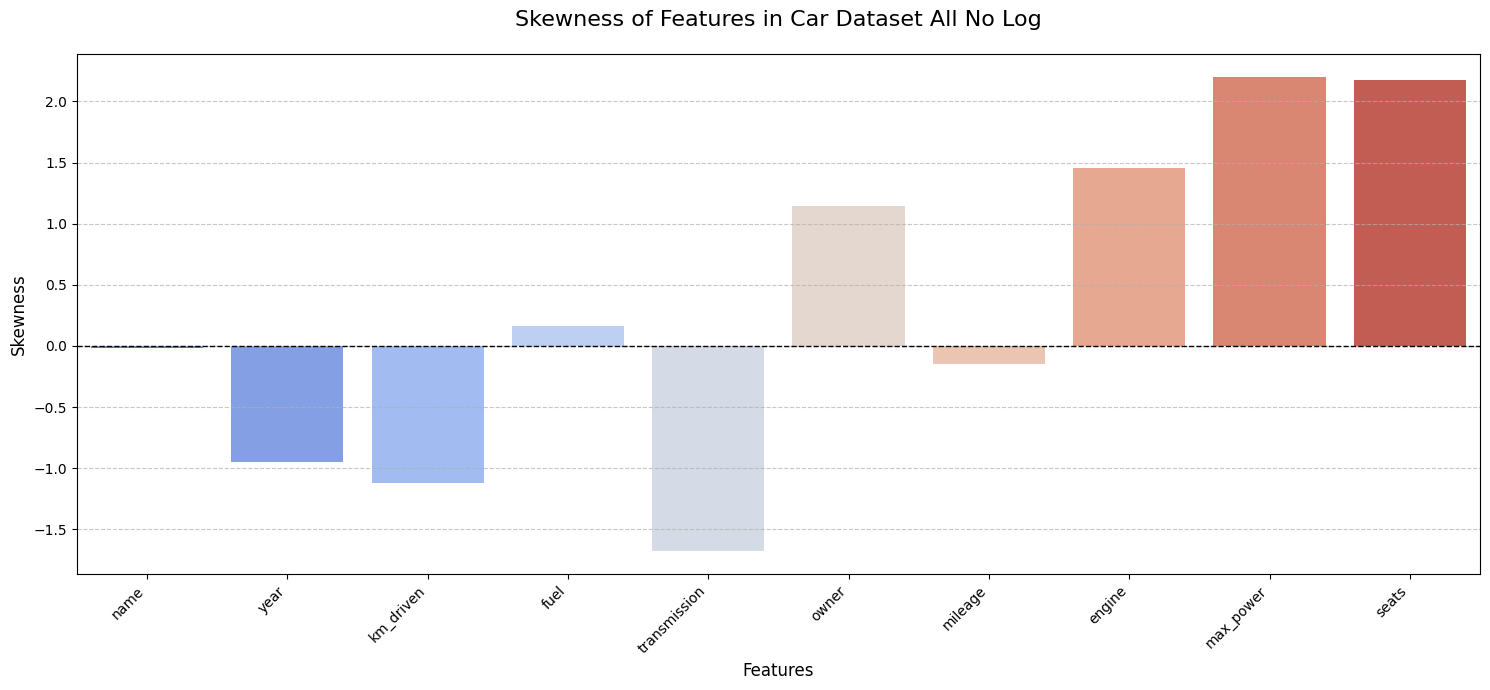

In [79]:
chart(preprocessed_dataset_2005_2010, '2005 đến 2010')
chart(preprocessed_dataset_2010_2015, '2010 đến 2015')
chart(preprocessed_dateset_2015_2021, '2015 đến 2021')
chart(preprocessed_dataset, 'All')
chart(preprocessed_dataset_2005_2010_noLog, '2005 đến 2010 No Log')
chart(preprocessed_dataset_2010_2015_noLog, '2010 đến 2015 No Log')
chart(preprocessed_dateset_2015_2021_noLog, '2015 đến 2021 No Log')
chart(preprocessed_df, 'All No Log')

# 5. Thống kê và xây dựng mô hình trên dữ liệu đã xử lý

## Load dữ liệu đã xử lý

In [80]:
preprocessed_df = pd.read_csv(saved_processed_data_path)
label_encoders = joblib.load(saved_label_encoders_path)

FileNotFoundError: [Errno 2] No such file or directory: ''

## Distribution of continuous columns

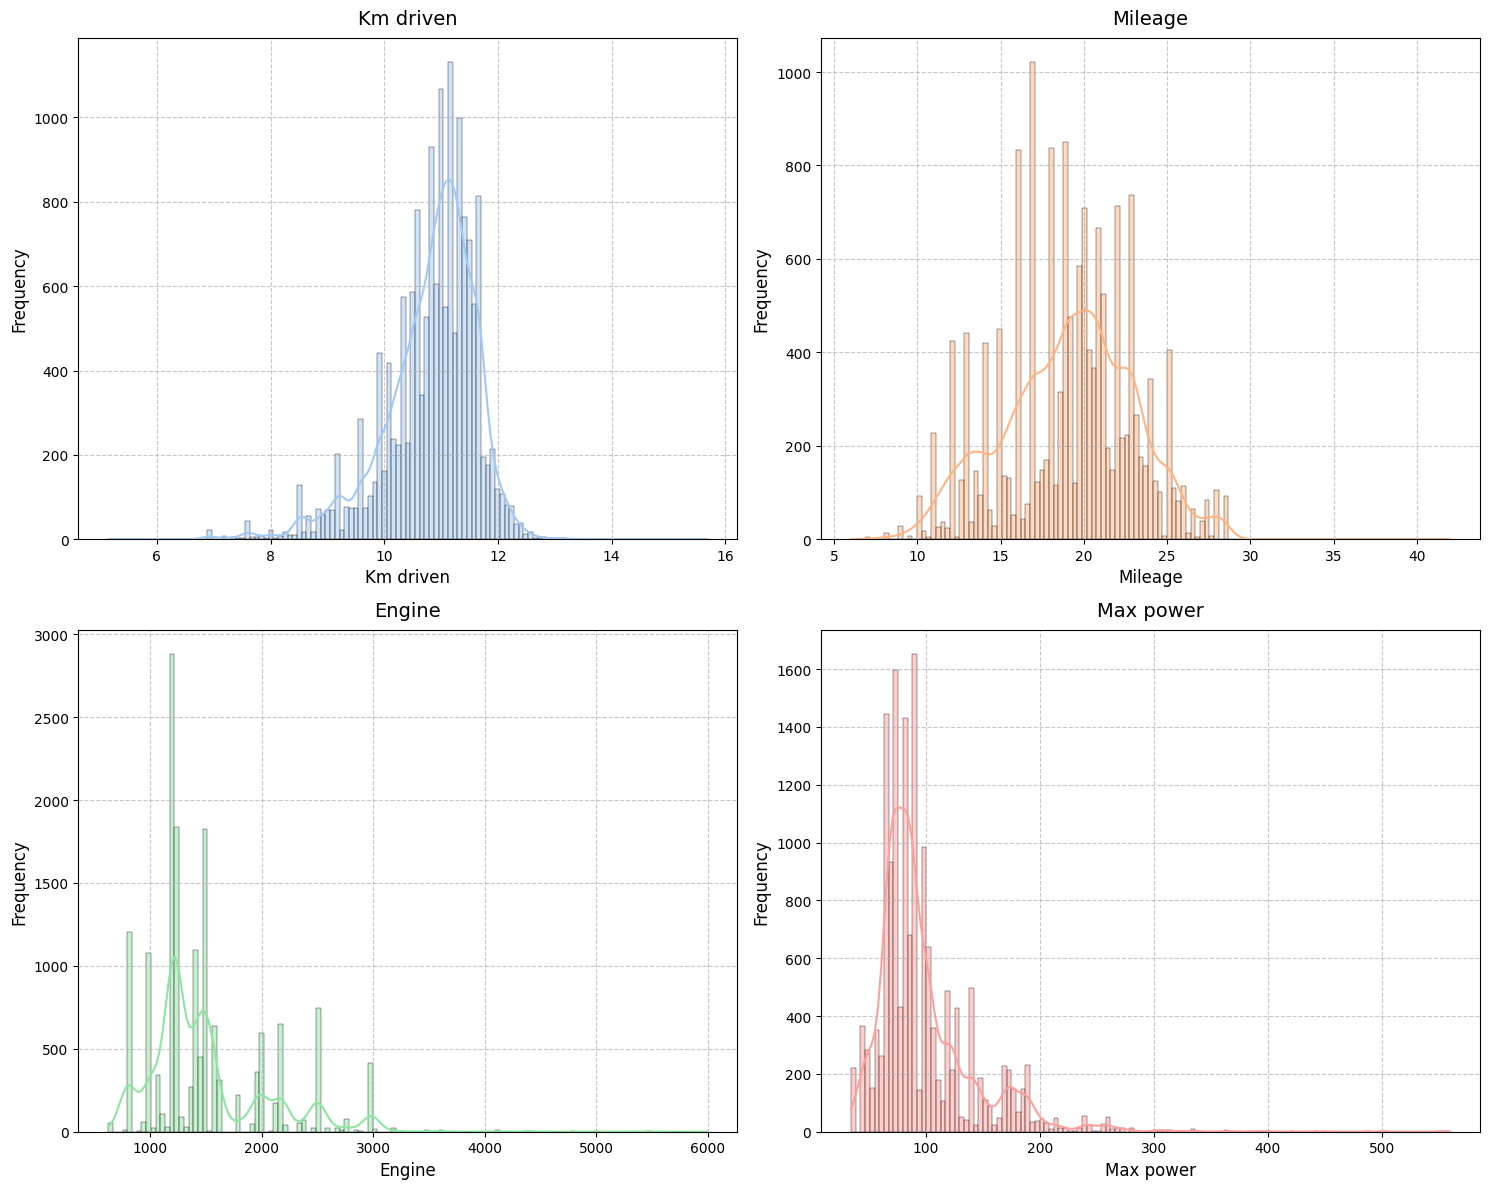

In [ ]:
plot_histograms(preprocessed_df, continuous_raw_columns)

## Correlation matrix

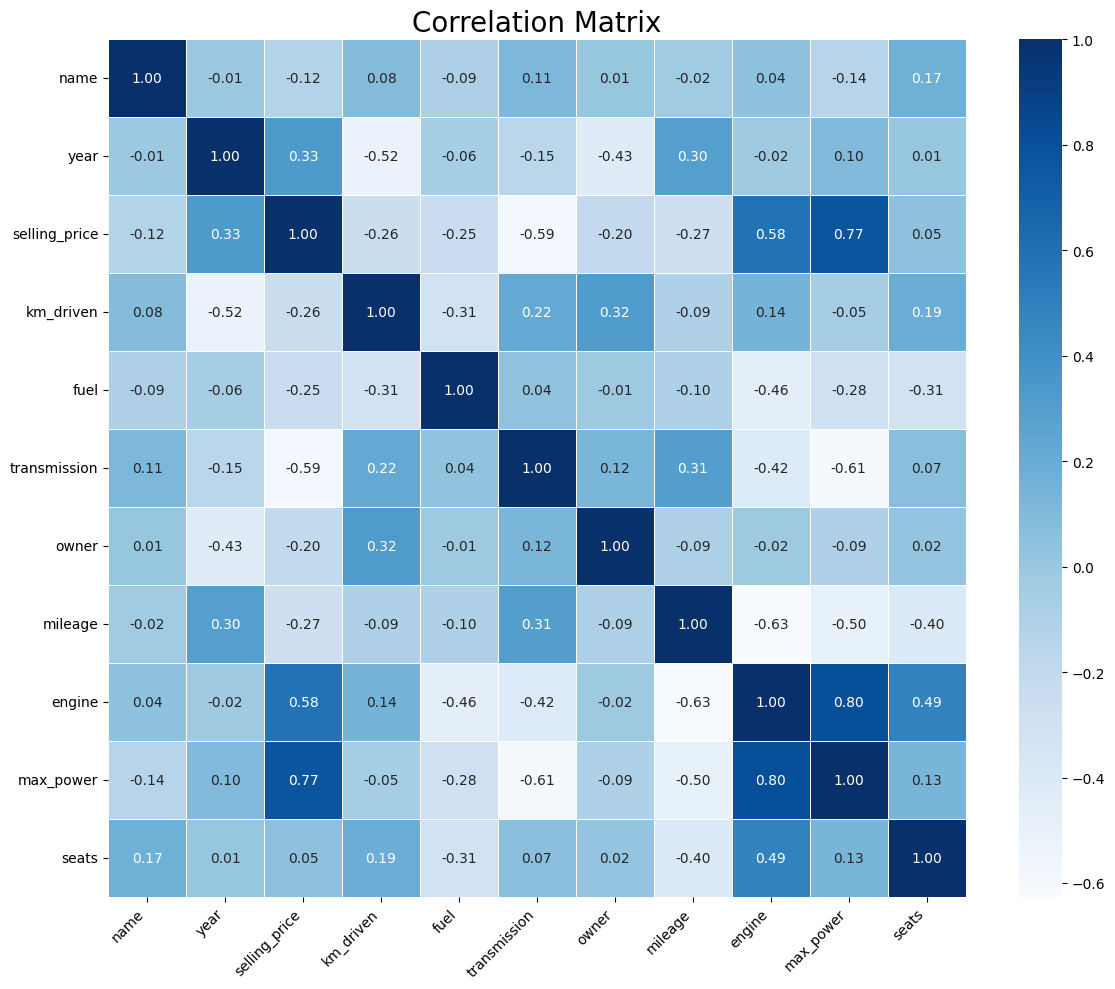

In [ ]:
# Compute the correlation matrix
correlation_matrix = preprocessed_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', 
            annot_kws={"size": 10}, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

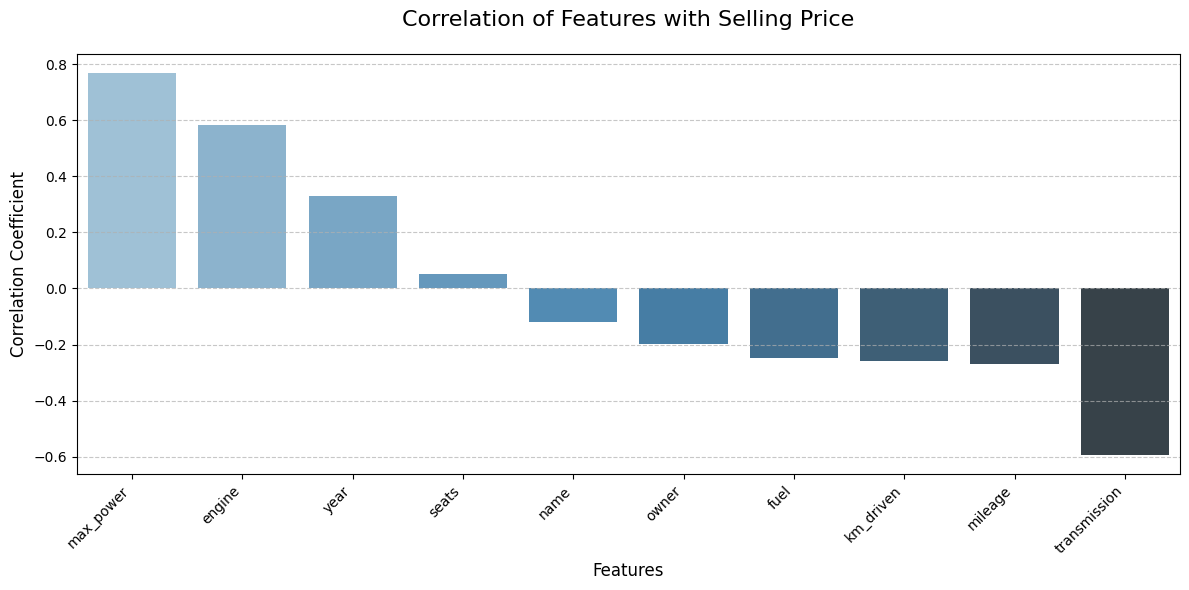

In [ ]:
# Remove the selling_price 
corr_with_price = correlation_matrix['selling_price'].drop('selling_price').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=corr_with_price.index, y=corr_with_price.values, 
            hue=corr_with_price.index, palette='Blues_d')

plt.title('Correlation of Features with Selling Price', fontsize=16, pad=20)

plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Overview of categorical columns

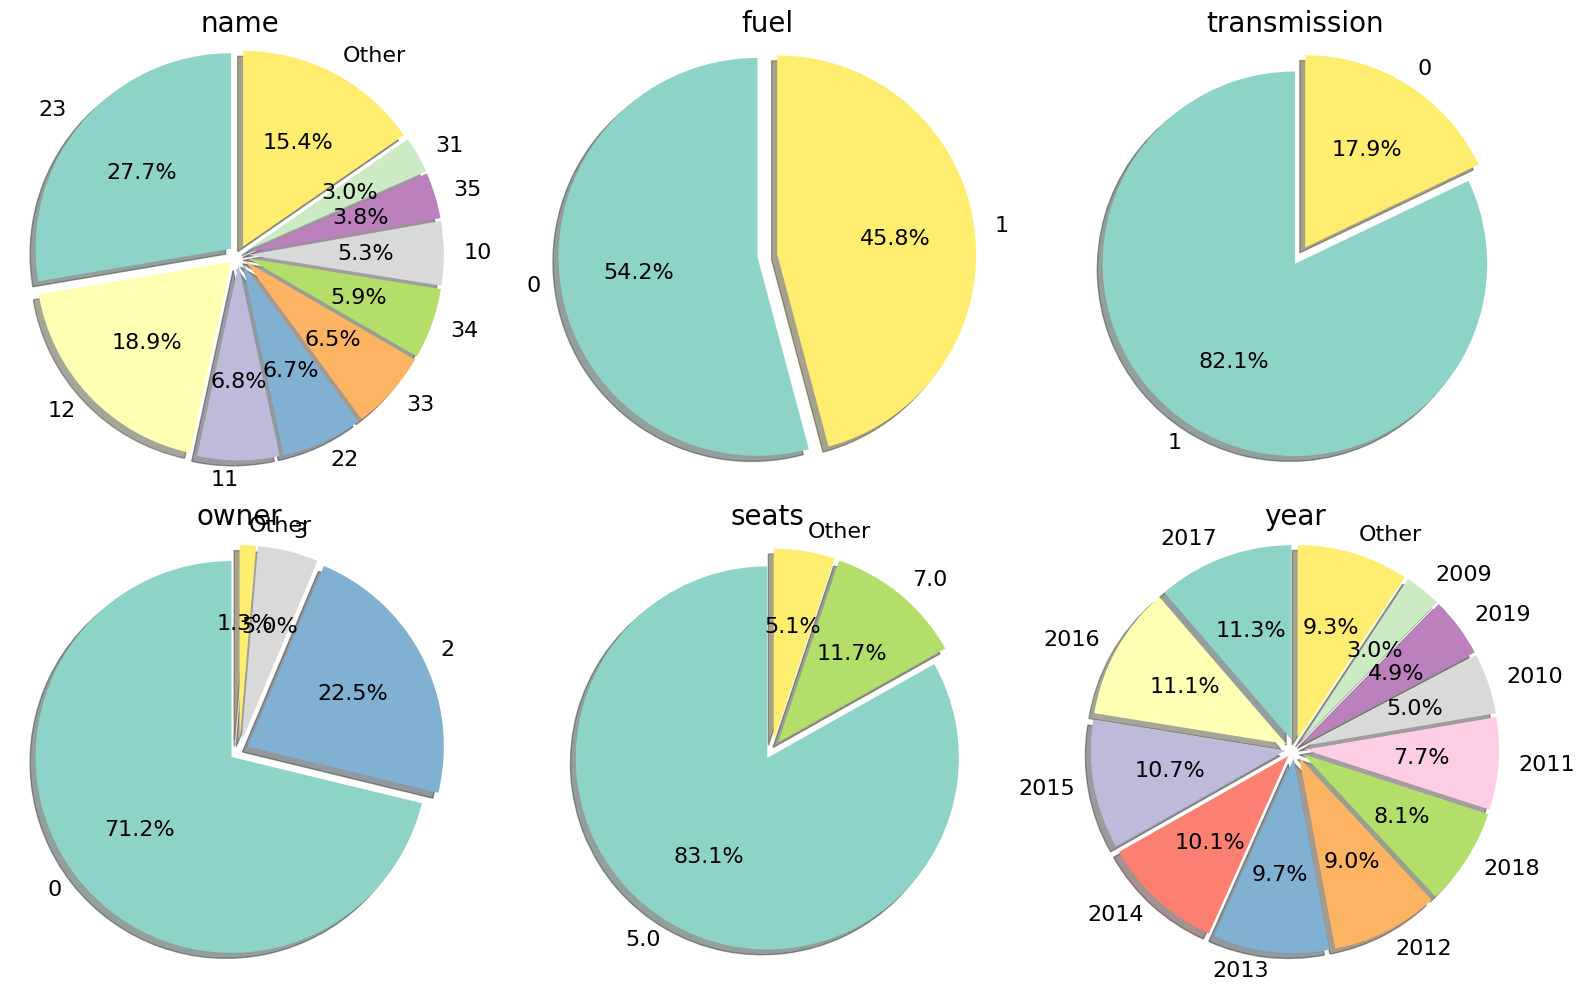

In [ ]:


categorical_columns = ['name', 'fuel', 'transmission', 'owner', 'seats', 'year']
threshold = 3.0

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()  # Làm phẳng mảng axes để dễ dàng lặp qua

def plot_pie_chart(df, column, ax, encoders):
    data = df[column]

    # Chỉ giải mã nếu cột đó đã được label encoding
    if column in encoders:
        data = encoders[column].inverse_transform(data)

    value_counts = pd.Series(data).value_counts()
    percentages = value_counts / value_counts.sum() * 100

    # Gom nhóm các giá trị nhỏ hơn threshold vào "Other"
    mask = percentages < threshold
    if mask.any():
        other_percentage = percentages[mask].sum()
        percentages = percentages[~mask]
        percentages['Other'] = other_percentage

    # Vẽ biểu đồ tròn với màu sắc dịu hơn
    colors = plt.cm.Set3(np.linspace(0, 1, len(percentages)))  
    wedges, texts, autotexts = ax.pie(
        percentages, labels=percentages.index, autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=[0.05] * len(percentages),
        colors=colors, textprops={'fontsize': 16}  # Tăng kích thước chữ
    )
    
    # Tăng kích thước chữ cho nhãn
    for text in texts:
        text.set_fontsize(16)
    for autotext in autotexts:
        autotext.set_fontsize(16)

    ax.axis('equal')
    ax.set_title(f'{column}', fontsize=20)  # Tăng kích thước tiêu đề

# Vẽ từng biểu đồ cho mỗi cột
for i, column in enumerate(categorical_columns):
    if column in preprocessed_df.columns and i < len(axes):
        plot_pie_chart(preprocessed_df, column, axes[i], label_encoders)

plt.tight_layout()
plt.show()


## Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Drop non-numeric columns (if necessary)
df_numeric = preprocessed_df.drop(columns=["name"])  # 'name' is a categorical feature

# Feature scaling (K-Means is sensitive to different scales)
cluestering_scaler = StandardScaler()
df_scaled = cluestering_scaler.fit_transform(df_numeric)



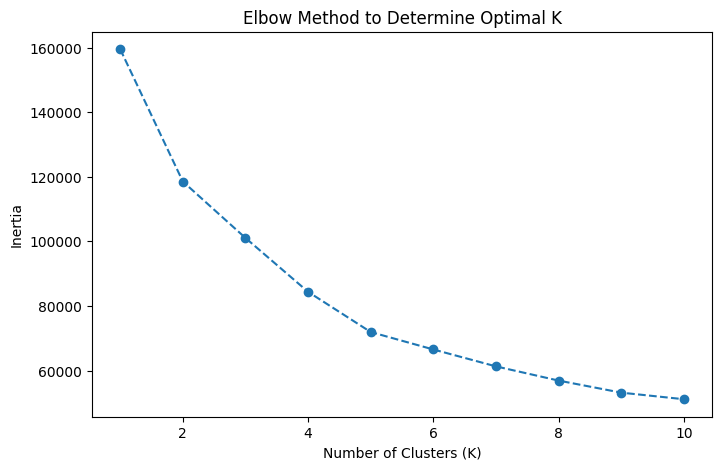

In [ ]:
# Find the optimal K using the Elbow method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method result
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()


In [ ]:
# Choose the optimal K (e.g., based on the elbow method)
optimal_k = 3  # Change this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_numeric["Cluster"] = kmeans.fit_predict(df_scaled)

# Add cluster labels to original dataframe
preprocessed_df["Cluster"] = df_numeric["Cluster"]


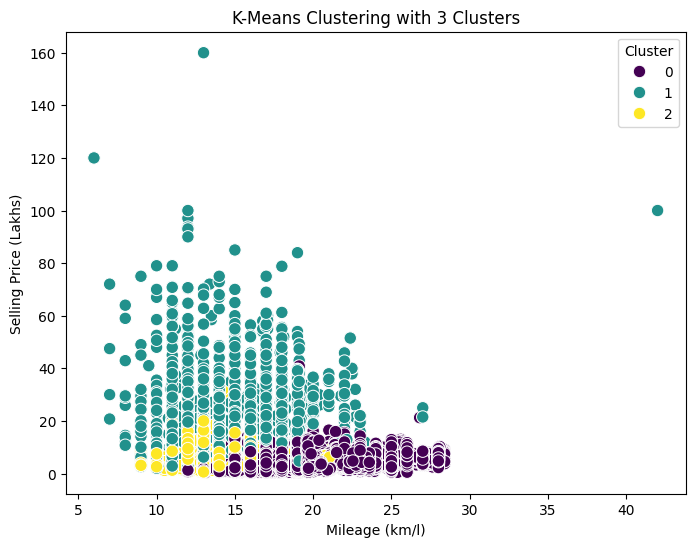

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=preprocessed_df["mileage"], y=preprocessed_df["selling_price"], hue=preprocessed_df["Cluster"], palette="viridis", s=80)
plt.xlabel("Mileage (km/l)")
plt.ylabel("Selling Price (Lakhs)")
plt.title(f"K-Means Clustering with {optimal_k} Clusters")
plt.legend(title="Cluster")
plt.show()


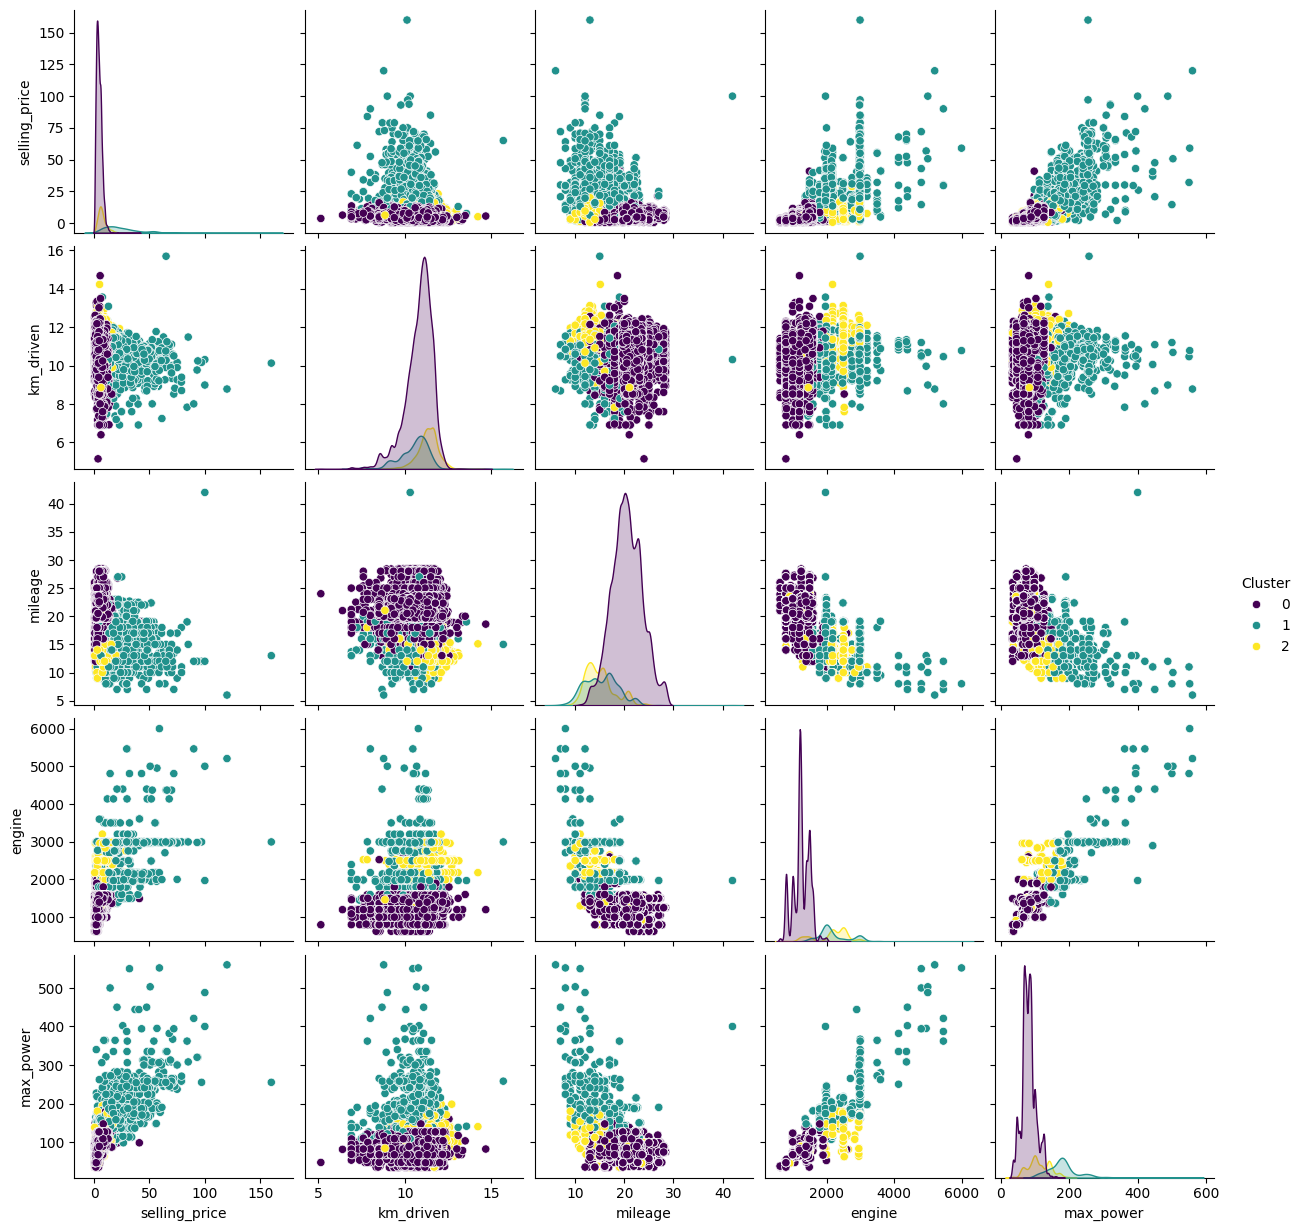

In [ ]:
# Chọn các cột số để vẽ biểu đồ
numeric_columns = ["selling_price", "km_driven", "mileage", "engine", "max_power"]

# Vẽ pairplot với hue là 'Cluster'
sns.pairplot(preprocessed_df, vars=numeric_columns, hue="Cluster", palette="viridis", markers='o')

# Hiển thị biểu đồ
plt.show()

In [ ]:
# Compute the average values for each cluster
cluster_summary = df_numeric.groupby("Cluster").mean()
cluster_summary


,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats
Cluster,,,,,,,,,,
0,2013.629574,4.372310,10.796039,0.561948,0.931281,0.631676,20.469761,1250.264057,81.275363,5.019346
1,2014.645905,24.464365,10.495752,0.250613,0.026974,0.338892,15.277274,2246.126999,182.300592,5.224129
2,2013.229321,7.345606,11.301654,0.058940,0.973254,0.774641,14.959351,2148.549777,111.278049,7.214958


## Modeling

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Split data into input and label data
X = preprocessed_df.drop(columns = ['selling_price'])
Y = preprocessed_df['selling_price']
print(f'size of input data {X.shape}')
print(f'size of input data {Y.shape}')
print(f'size of input data {preprocessed_df.shape}')

size of input data (15947, 11)
size of input data (15947,)
size of input data (15947, 12)


In [ ]:
# Split data into train and test data
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.12, random_state = 42)
# print(f'x train size {x_train.shape}, x test size {x_test.shape}')
# print(f'y train size {y_train.shape}, y test size {y_test.shape}')

In [ ]:
x_train = X[(X['year'] >= 2005) & (X['year'] < 2010)]
y_train = preprocessed_df[(preprocessed_df['year'] >= 2005) & (preprocessed_df['year'] < 2010)]['selling_price']
x_test = X[(X['year'] >= 2010) & (X['year'] < 2015)]
y_test = preprocessed_df[(preprocessed_df['year'] >= 2010) & (preprocessed_df['year'] < 2015)]['selling_price']
print(f'x train size {x_train.shape}, x test size {x_test.shape}')
print(f'y train size {y_train.shape}, y test size {y_test.shape}')

x train size (1565, 11), x test size (6608, 11)
y train size (1565,), y test size (6608,)


In [ ]:
# Normalize data (fit on train, transform on test)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)



In [ ]:
# Create all models
models = {
    'Linear Regression': LinearRegression(), 
    'Ridge': Ridge(),
    'Lasso': Lasso(), 
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [ ]:
results = []
best_model = None
best_model_name = None
best_mse = float('inf')

# Iterate over each model in the models dictionary
for name, model in models.items():
    # Fit the model on the scaled training data
    model.fit(x_train_scaled, y_train)
    
    # Predict on training and testing datasets
    train_pred = model.predict(x_train_scaled)
    test_pred = model.predict(x_test_scaled)
    
    # Calculate evaluation metrics for training data
    train_mse = mean_squared_error(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    
    # Calculate evaluation metrics for testing data
    test_mse = mean_squared_error(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Append all metrics to results list
    results.append({
        'Model': name,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R^2': train_r2,
        'Test R^2': test_r2
    })
    
    # Update the best model based on Test MSE
    if test_mse < best_mse:
        best_mse = test_mse
        best_model = model
        best_model_name = name

# Create a DataFrame to display results
df_results = pd.DataFrame(results)
df_results

,Model,Train MSE,Test MSE,Train MAE,Test MAE,Train R^2,Test R^2
0,Linear Regression,4.929833,22.090459,1.088633,1.976868,0.558544,0.458164
1,Ridge,4.929838,22.096609,1.088298,1.976636,0.558543,0.458013
2,Lasso,6.519100,36.214531,1.153418,2.825591,0.416228,0.111728
3,Decision Tree,0.004105,25.808757,0.012353,2.501304,0.999632,0.366962
4,KNN,3.289948,23.275692,0.656022,2.422179,0.705392,0.429093
5,Random Forest,0.687886,19.406579,0.288465,2.170404,0.938401,0.523994


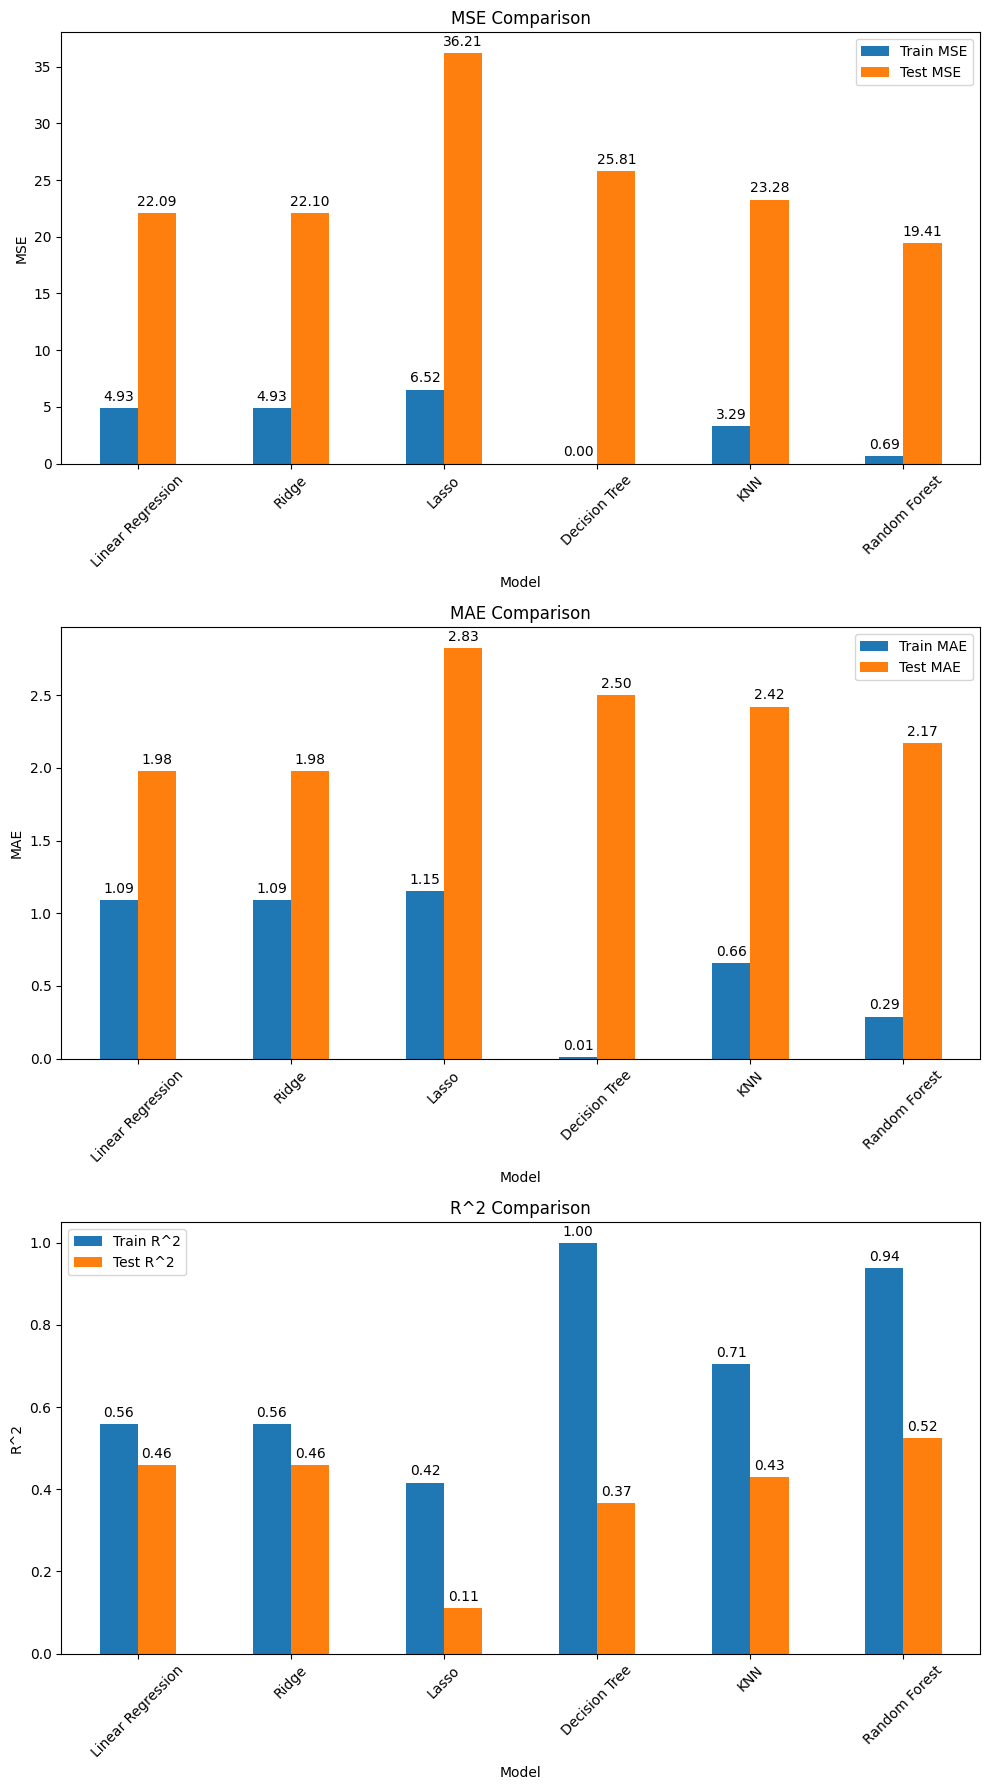

In [ ]:
# Define the metrics and their corresponding DataFrame columns
metrics = [
    ('MSE', 'Train MSE', 'Test MSE'),
    ('MAE', 'Train MAE', 'Test MAE'),
    ('R^2', 'Train R^2', 'Test R^2')
]

# Create subplots: one row per metric
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 18))

# Loop over each metric to plot its bar chart
for ax, (metric_name, train_col, test_col) in zip(axes, metrics):
    # Set Model as index and select the current metric columns
    df_plot = df_results.set_index('Model')[[train_col, test_col]]
    
    # Plot the bar chart for the current metric
    df_plot.plot(kind='bar', ax=ax, rot=45, title=f"{metric_name} Comparison")
    
    # Add data labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    # Set the y-axis label
    ax.set_ylabel(metric_name)

plt.tight_layout()
plt.show()


In [ ]:
joblib.dump(best_model, "best_model.pkl")
print(f"Saved {best_model_name} to best_model.pkl")

Saved Random Forest to best_model.pkl


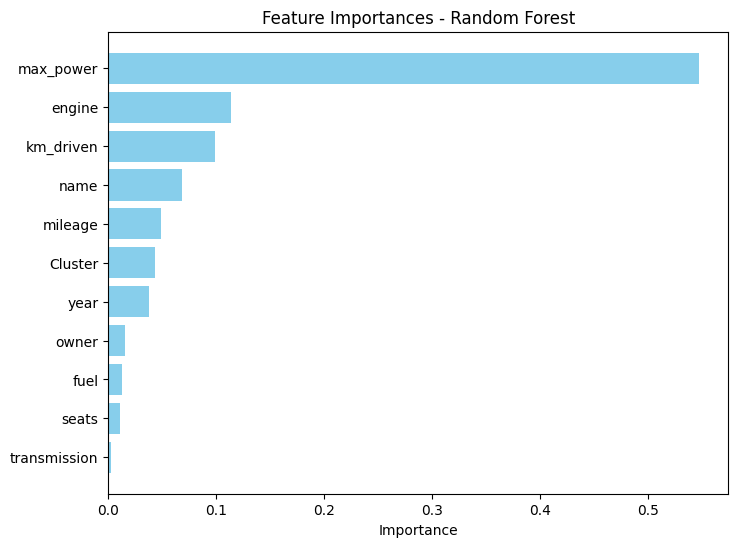

In [ ]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Sắp xếp giảm dần theo độ quan trọng
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color='skyblue')
    plt.gca().invert_yaxis()  # Để feature cao nhất ở trên cùng
    plt.title(f"Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.show()
else:
    print(f"The model {best_model_name} does not have the 'feature_importances_' attribute")


## Load the best model

In [ ]:
# Load model
loaded_model = joblib.load("best_model.pkl")

# Predict
predictions = loaded_model.predict(x_test_scaled)


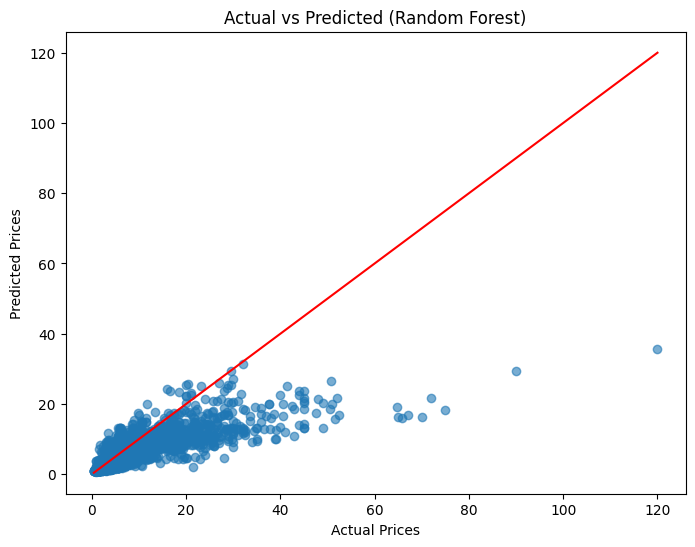

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()


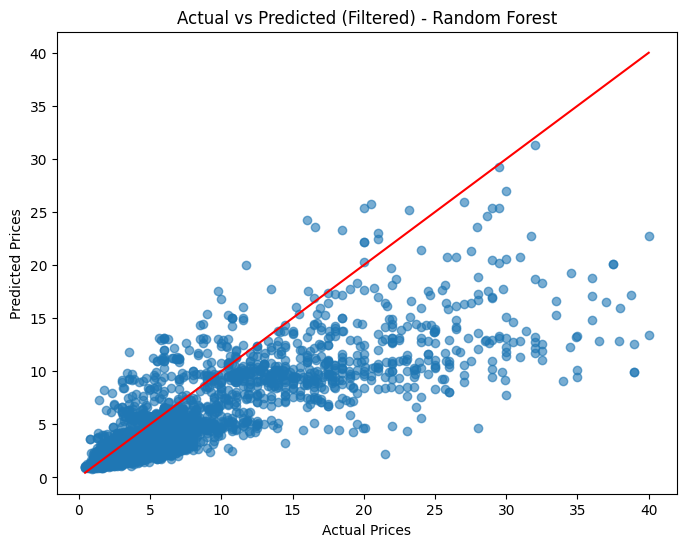

In [ ]:
# Define threshold
y_threshold = max(y_test) / 3

mask = y_test <= y_threshold
filtered_y_test = y_test[mask]
filtered_predictions = predictions[mask]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_y_test, filtered_predictions, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted (Filtered) - {best_model_name}")
plt.plot([min(filtered_y_test), max(filtered_y_test)], 
         [min(filtered_y_test), max(filtered_y_test)], color='red')
plt.show()


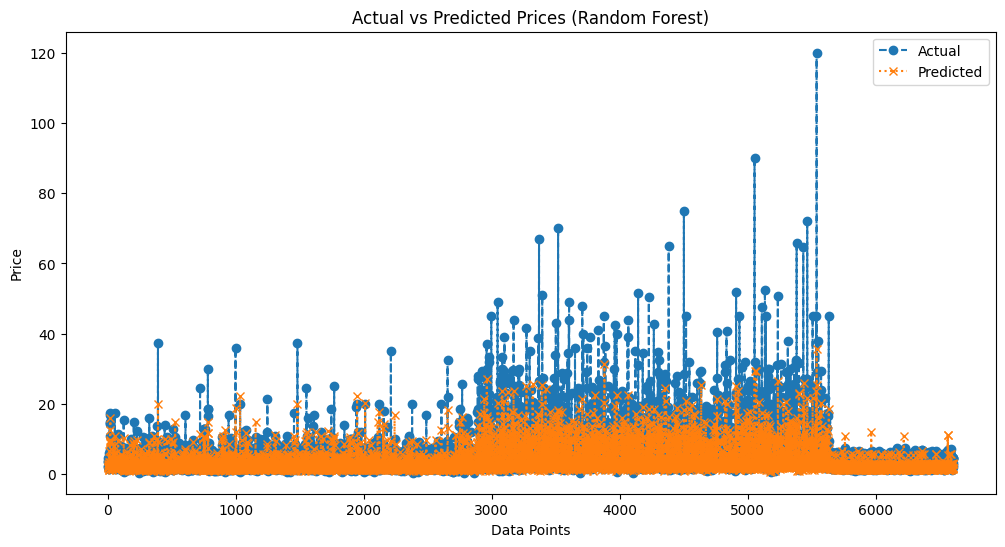

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker='o', linestyle='dashed')
plt.plot(predictions, label="Predicted", marker='x', linestyle='dotted')
plt.xlabel("Data Points")
plt.ylabel("Price")
plt.title(f"Actual vs Predicted Prices ({best_model_name})")
plt.legend()
plt.show()
